# Seminar Paper

Agenda:
1. Graph Creation
1. Transaction based analysis
2. Scraped data extention
3. Outlook

In [36]:
import graph_tool.all as gt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import dill as pickle
from collections import defaultdict
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import sys
import os
import time

# Graph Creation

### Graph Loading

In [10]:
graph = gt.load_graph("raw_bitcoin_data_and_graph_creation/BitcoinGraph.gt")
print("Graph loaded.")

with open("raw_bitcoin_data_and_graph_creation/revmap.pkl", "rb") as f:
    reverse_map = pickle.load(f)
print("Reverse map loaded.")

Graph loaded.
Reverse map loaded.


### Graph Exploration

In [11]:
print("Node Properties:")
for prop_name, prop_map in graph.vp.items():
    print(f"Property Name: {prop_name}, Type: {prop_map.value_type()}")

print("\nEdge Properties:")
for prop_name, prop_map in graph.ep.items():
    print(f"Property Name: {prop_name}, Type: {prop_map.value_type()}")


Node Properties:
Property Name: tx_hash, Type: string
Property Name: tx_inputs_count, Type: double
Property Name: tx_inputs_value, Type: double
Property Name: tx_outputs_count, Type: double
Property Name: tx_outputs_value, Type: double
Property Name: tx_block_height, Type: double
Property Name: tx_block_time, Type: double
Property Name: tx_fee, Type: double
Property Name: tx_size, Type: double
Property Name: address, Type: string
Property Name: prev_type, Type: string
Property Name: next_type, Type: string

Edge Properties:
Property Name: value, Type: double
Property Name: time, Type: int32_t
Property Name: tx_type, Type: string


In [12]:
# graph properties
print(f"Number of nodes in the graph: {graph.num_vertices()}")
print(f"Number of edges in the graph: {graph.num_edges()}")
print(f"Keys in reverse_map: {reverse_map.keys()}")

Number of nodes in the graph: 7523508
Number of edges in the graph: 19421194
Keys in reverse_map: dict_keys(['transaction_dict', 'account_dict'])


In [13]:
print(f"Reverse map loaded with {len(reverse_map.get('account_dict', {}))} address entries.")
print(f"Reverse map loaded with {len(reverse_map.get('transaction_dict', {}))} transaction entries.")


Reverse map loaded with 2636373 address entries.
Reverse map loaded with 4887134 transaction entries.


## Graph Visualization

In [14]:
# Parameters
max_recent_blocks = 50  # recent blocks to filter transactions
max_neighbors = 10       # max number of neighbors to include in the subgraph

# max block height in the graph
max_block_height = max(graph.vp.tx_block_height)

## filtering
def filter_recent_transactions(graph, max_block_height, max_recent_blocks):
    recent_txs = []
    for v in graph.vertices():
        if graph.vp.tx_hash[v]:  # Check if it's a transaction node
            tx_height = graph.vp.tx_block_height[v]
            if tx_height >= (max_block_height - max_recent_blocks):
                recent_txs.append(v)
    return recent_txs

recent_txs = filter_recent_transactions(graph, max_block_height, max_recent_blocks)
print(f"Found {len(recent_txs)} transactions in the last {max_recent_blocks} blocks.")

# subgraph creation
def create_subgraph_for_recent_txs(graph, recent_txs, max_neighbors):
    sub_vertices = set(recent_txs)
    
    for tx in recent_txs:
        neighbors = list(tx.all_neighbors())
        if len(neighbors) > max_neighbors:
            neighbors = np.random.choice(neighbors, max_neighbors, replace=False)
        sub_vertices.update(neighbors)

    vfilt = graph.new_vertex_property('bool')
    for v in sub_vertices:
        vfilt[v] = True

    return gt.GraphView(graph, vfilt)

recent_sub_graph = create_subgraph_for_recent_txs(graph, recent_txs, max_neighbors)
print(f"Subgraph created with {recent_sub_graph.num_vertices()} vertices and {recent_sub_graph.num_edges()} edges")

Found 231776 transactions in the last 50 blocks.
Subgraph created with 329629 vertices and 902705 edges


Subgraph created with 302 vertices and 453 edges


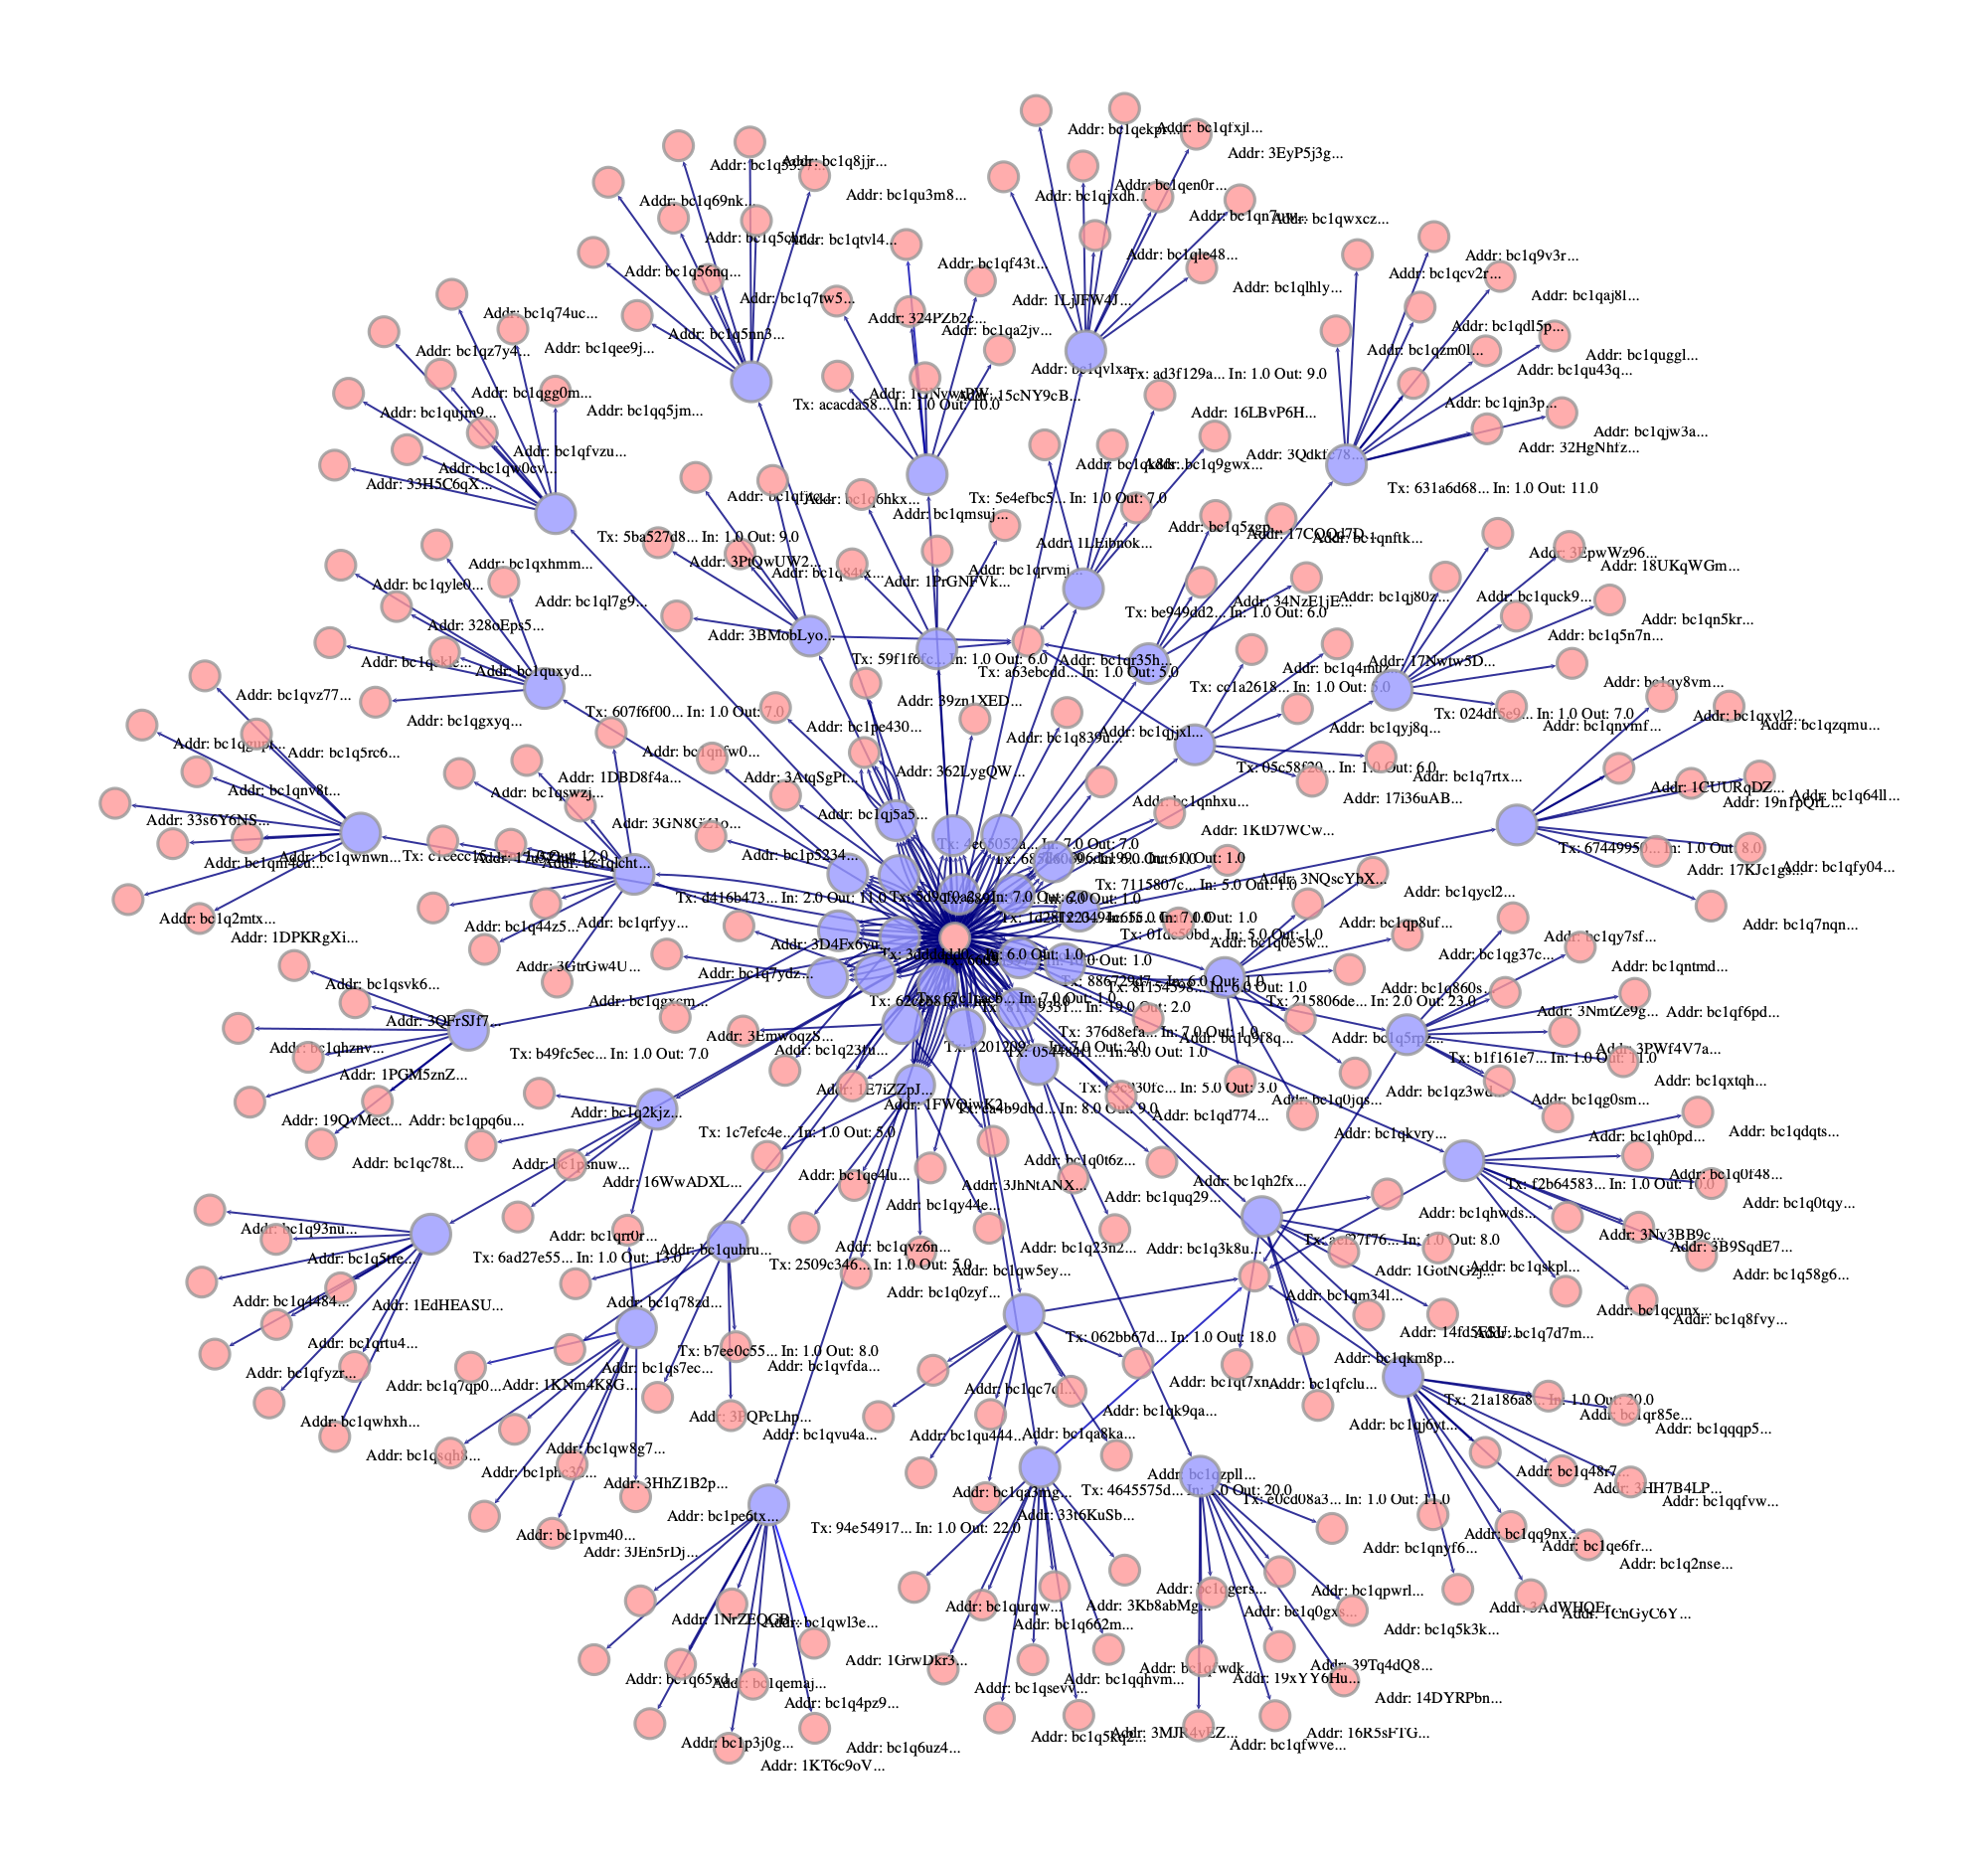

<Figure size 2000x2000 with 0 Axes>

In [16]:
min_io_count = 5
max_transactions = 50
max_neighbors = 10

## filtering
def find_complex_transactions(graph, min_io_count, max_transactions):
    complex_txs = []
    for v in graph.vertices():
        if graph.vp.tx_hash[v]:
            if (graph.vp.tx_inputs_count[v] >= min_io_count or
                graph.vp.tx_outputs_count[v] >= min_io_count):
                complex_txs.append(v)
                if len(complex_txs) >= max_transactions:
                    break
    return complex_txs[:max_transactions]

complex_txs = find_complex_transactions(graph, min_io_count, max_transactions)

def create_subgraph(graph, complex_txs, max_neighbors):
    sub_vertices = set(complex_txs)
    for tx in complex_txs:
        neighbors = list(tx.all_neighbors())
        if len(neighbors) > max_neighbors:
            neighbors = np.random.choice(neighbors, max_neighbors, replace=False)
        sub_vertices.update(neighbors)

    vfilt = graph.new_vertex_property('bool')
    for v in sub_vertices:
        vfilt[v] = True
    return gt.GraphView(graph, vfilt)

sub_graph = create_subgraph(graph, complex_txs, max_neighbors)
print(f"Subgraph created with {sub_graph.num_vertices()} vertices and {sub_graph.num_edges()} edges")


v_color = sub_graph.new_vertex_property("vector<double>")
v_size = sub_graph.new_vertex_property("double")
v_label = sub_graph.new_vertex_property("string")

for v in sub_graph.vertices():
    if sub_graph.vp.tx_hash[v]:  # transaction node
        v_color[v] = [0.6, 0.6, 1.0, 0.8]  # blue
        v_size[v] = 20
        v_label[v] = f"Tx: {sub_graph.vp.tx_hash[v][:8]}...\n" \
                     f"In: {sub_graph.vp.tx_inputs_count[v]}\n" \
                     f"Out: {sub_graph.vp.tx_outputs_count[v]}"
    else:  # address node
        v_color[v] = [1.0, 0.6, 0.6, 0.8]  # red
        v_size[v] = 15
        v_label[v] = f"Addr: {sub_graph.vp.address[v][:8]}..."

e_color = sub_graph.new_edge_property("vector<double>")
max_value = max(sub_graph.ep.value) if sub_graph.num_edges() > 0 else 1
for e in sub_graph.edges():
    intensity = 0.5 + 0.5 * (sub_graph.ep.value[e] / max_value)
    e_color[e] = [0, 0, intensity, 0.8]

pos = gt.sfdp_layout(sub_graph)

plt.figure(figsize=(20, 20))
gt.graph_draw(sub_graph, pos=pos, vertex_fill_color=v_color,
              vertex_size=v_size, vertex_text=v_label,
              vertex_font_size=8, vertex_text_position=0.5,
              edge_color=e_color, edge_pen_width=1,
              output_size=(1000, 1000))


plt.show()

In [17]:
tx_count = sum(1 for v in sub_graph.vertices() if sub_graph.vp.tx_hash[v])
addr_count = sum(1 for v in sub_graph.vertices() if sub_graph.vp.address[v])
print(f"Number of transactions in visualization: {tx_count}")
print(f"Number of addresses in visualization: {addr_count}")

Number of transactions in visualization: 50
Number of addresses in visualization: 252


# Transaction based analysis

## Feature extraction

In [18]:
def extract_transaction_features(graph, reverse_map):
    features = []

    for tx_hash, tx_index in reverse_map["transaction_dict"].items():
        tx_vertex = graph.vertex(tx_index)
        num_inputs = graph.vp["tx_inputs_count"][tx_vertex]
        num_outputs = graph.vp["tx_outputs_count"][tx_vertex]
        total_input_value = graph.vp["tx_inputs_value"][tx_vertex]
        total_output_value = graph.vp["tx_outputs_value"][tx_vertex]
        tx_fee = graph.vp["tx_fee"][tx_vertex]
        tx_size = graph.vp["tx_size"][tx_vertex]

        features.append({
            "tx_hash": tx_hash,
            "num_inputs": num_inputs,
            "num_outputs": num_outputs,
            "total_input_value": total_input_value,
            "total_output_value": total_output_value,
            "transaction_fee": tx_fee,
            "tx_size": tx_size
        })

    return pd.DataFrame(features)

# extracting features using reverse_map
df_features = extract_transaction_features(graph, reverse_map)

df_features.to_csv("extracted_transaction_features.csv")


In [ ]:
## colab path
#from google.colab import drive
#drive.mount('/content/drive')
#df_features = pd.read_csv("/content/drive/MyDrive/data_bit/extracted_transaction_features.csv")

In [ ]:
##df_features = pd.read_csv("extracted_transaction_features.csv")

In [19]:
df_features

tx_hash  num_inputs  \
0        ab337ef34258135fed95bbf12450d70c367e9f80c3f5c0...         1.0   
1        a66f26d80c0a248a1748c6db13e0e49aaf72c046a3fa00...         1.0   
2        f00dd29c79bafcca88b1dd0596fad90e63a1343c9627e9...         2.0   
3        359f686eb426478c4bb6a6579683c55876e62c339d27e2...         1.0   
4        165d101703ed91dfe830b0488ffdeb5c6ab25711a93efa...         1.0   
...                                                    ...         ...   
4887129  55bb5e0ecd815d68c865353f01b0dd78fce1fefa24145c...        20.0   
4887130  a954e993df29e5439c229cd3885dd9de3b0bb2f6831923...         5.0   
4887131  3c5a7642c175c9d1c5f3998462ca36a925c802339cbf06...         1.0   
4887132  3d8a9f14c20bd2c9387095b25aba4725e60fd922f99c29...         1.0   
4887133  43bf052d6df274fd4d3f27e5bf8de57b55c7f87e4632cb...         1.0   

         num_outputs  total_input_value  total_output_value  transaction_fee  \
0                3.0                0.0        3.510377e-08     0.000000e+00   
1                1.0                0.0        2.847879e-10     1.521210e-11   
2                2.0                0.0        1.693855e-09     2.787950e-11   
3                2.0                0.0        8.347858e-10     1.921420e-11   
4                2.0                0.0        8.236641e-10     1.933590e-11   
...              ...                ...                 ...              ...   
4887129          1.0                0.0        2.174709e-09     9.305000e-13   
4887130          7.0                0.0        1.892387e-09     3.335000e-13   
4887131          1.0                0.0        5.275050e-11     4.950000e-14   
4887132          2.0                0.0        1.836000e-13     6.450000e-14   
4887133          2.0                0.0        5.706000e-13     6.450000e-14   

         tx_size  
0          257.0  
1          193.0  
2          394.0  
3          239.0  
4          240.0  
...          ...  
4887129   3468.0  
4887130   1039.0  
4887131    150.0  
4887132    211.0  
4887133    210.0  

[4887134 rows x 7 columns]

In [20]:
print(df_features.describe())

         num_inputs   num_outputs  total_input_value  total_output_value  \
count  4.887134e+06  4.887134e+06          4887134.0        4.887134e+06   
mean   1.600317e+00  2.373626e+00                0.0        1.093352e-08   
std    1.134954e+01  8.647009e+00                0.0        7.208526e-07   
min    1.000000e+00  1.000000e+00                0.0        0.000000e+00   
25%    1.000000e+00  2.000000e+00                0.0        5.208000e-13   
50%    1.000000e+00  2.000000e+00                0.0        2.603000e-12   
75%    1.000000e+00  2.000000e+00                0.0        1.531720e-11   
max    1.537000e+03  2.128000e+03                0.0        7.517739e-04   

       transaction_fee       tx_size  
count     4.887134e+06  4.887134e+06  
mean      1.372733e-13  3.340408e+02  
std       1.977569e-12  2.211742e+03  
min       0.000000e+00  1.380000e+02  
25%       3.360000e-14  2.070000e+02  
50%       3.770000e-14  2.080000e+02  
75%       6.420000e-14  2.220000e+02  
max

In [21]:
##df_features = df_features.drop(columns=['Unnamed: 0']) ## only when loading file from csv
df_features = df_features.drop(columns=['total_input_value'])
df_features['input_output_ratio'] = df_features['num_inputs'] / df_features['num_outputs'].replace(0, np.nan)
df_features['fee_per_byte'] = df_features['transaction_fee'] / df_features['tx_size'].replace(0, np.nan)
df_features.fillna(0, inplace=True)
df_features

tx_hash  num_inputs  \
0        ab337ef34258135fed95bbf12450d70c367e9f80c3f5c0...         1.0   
1        a66f26d80c0a248a1748c6db13e0e49aaf72c046a3fa00...         1.0   
2        f00dd29c79bafcca88b1dd0596fad90e63a1343c9627e9...         2.0   
3        359f686eb426478c4bb6a6579683c55876e62c339d27e2...         1.0   
4        165d101703ed91dfe830b0488ffdeb5c6ab25711a93efa...         1.0   
...                                                    ...         ...   
4887129  55bb5e0ecd815d68c865353f01b0dd78fce1fefa24145c...        20.0   
4887130  a954e993df29e5439c229cd3885dd9de3b0bb2f6831923...         5.0   
4887131  3c5a7642c175c9d1c5f3998462ca36a925c802339cbf06...         1.0   
4887132  3d8a9f14c20bd2c9387095b25aba4725e60fd922f99c29...         1.0   
4887133  43bf052d6df274fd4d3f27e5bf8de57b55c7f87e4632cb...         1.0   

         num_outputs  total_output_value  transaction_fee  tx_size  \
0                3.0        3.510377e-08     0.000000e+00    257.0   
1                1.0        2.847879e-10     1.521210e-11    193.0   
2                2.0        1.693855e-09     2.787950e-11    394.0   
3                2.0        8.347858e-10     1.921420e-11    239.0   
4                2.0        8.236641e-10     1.933590e-11    240.0   
...              ...                 ...              ...      ...   
4887129          1.0        2.174709e-09     9.305000e-13   3468.0   
4887130          7.0        1.892387e-09     3.335000e-13   1039.0   
4887131          1.0        5.275050e-11     4.950000e-14    150.0   
4887132          2.0        1.836000e-13     6.450000e-14    211.0   
4887133          2.0        5.706000e-13     6.450000e-14    210.0   

         input_output_ratio  fee_per_byte  
0                  0.333333  0.000000e+00  
1                  1.000000  7.881917e-14  
2                  1.000000  7.076015e-14  
3                  0.500000  8.039414e-14  
4                  0.500000  8.056625e-14  
...                     ...           ...  
4887129           20.000000  2.683103e-16  
4887130            0.714286  3.209817e-16  
4887131            1.000000  3.300000e-16  
4887132            0.500000  3.056872e-16  
4887133            0.500000  3.071429e-16  

[4887134 rows x 8 columns]

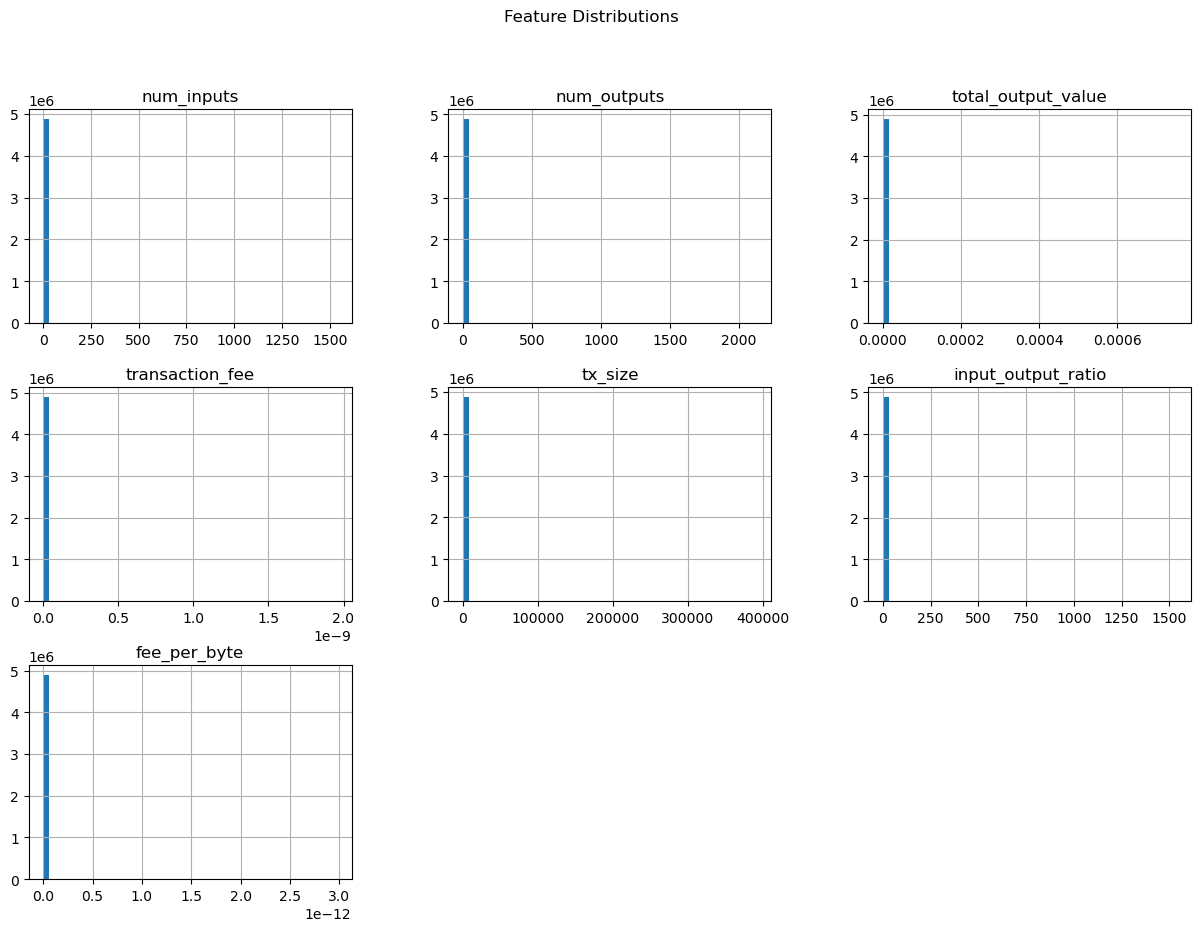

In [22]:
df_features.hist(bins=50, figsize=(15, 10))
plt.suptitle('Feature Distributions')
plt.show()


In [23]:
# non-numeric columns
non_numeric_columns = df_features.select_dtypes(include=['object']).columns
print("Non-numeric columns found:", non_numeric_columns)


def remove_outliers_iqr(df, lower_quantile, upper_quantile, multiplier=3):
    for col in df.select_dtypes(include=[np.number]).columns:  # only numeric columns
        Q1 = df[col].quantile(lower_quantile)
        Q3 = df[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

# less aggressive outlier removal
df_features = remove_outliers_iqr(df_features, lower_quantile = 0.05, upper_quantile= 0.95)

print(f"Data size after outlier removal: {df_features.shape}")



Non-numeric columns found: Index(['tx_hash'], dtype='object')
Data size after outlier removal: (4501291, 8)


In [24]:
features_to_transform = ['num_inputs', 'num_outputs', 'total_output_value', 'transaction_fee', 'tx_size',  'fee_per_byte', 'input_output_ratio']

# log1p transformation to handle skewness
for feature in features_to_transform:
    df_features[feature] = np.log1p(df_features[feature])


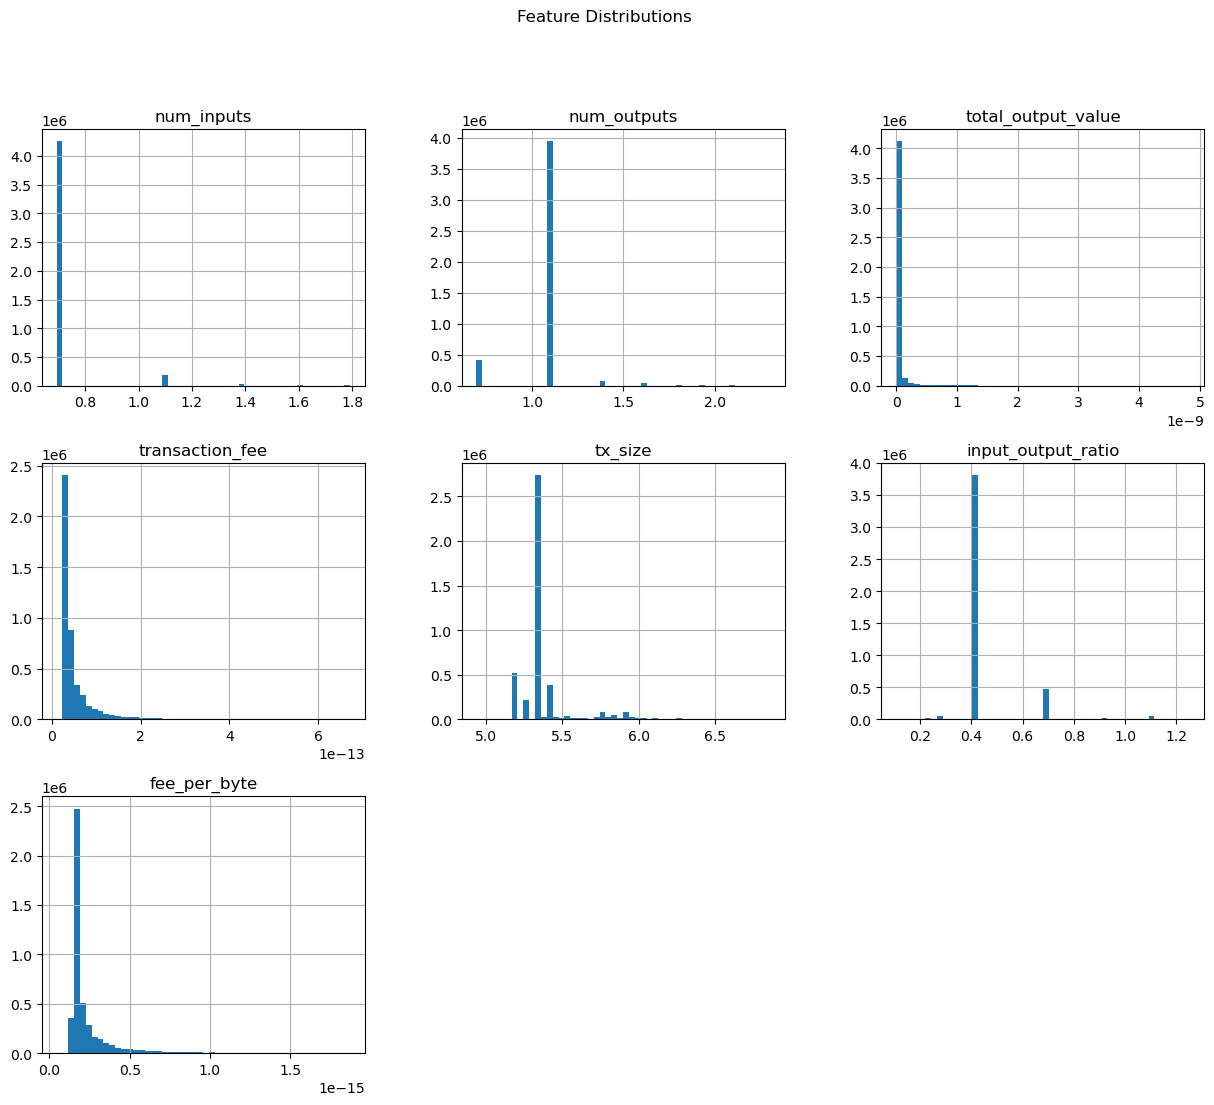

In [25]:
# histograms to check
df_features.hist(bins=50, figsize=(15, 12))
plt.suptitle('Feature Distributions')
plt.show()

In [26]:
## used for testing
#df_features_subset = df_features.sample(100000, random_state=42)

tx_hashes = df_features['tx_hash'].values

scaler = StandardScaler()
df_features_normalized = scaler.fit_transform(df_features.drop(columns=['tx_hash']))


In [27]:
tx_hashes

array(['d8f5593d37433dcc02c88c28995a94cbf18a7325714e9aec11482fbf7844d307',
       '695728f2b0676df9465e916f0fffed4ac9636f84f9512d2a78915bb60f217640',
       '00cc6d2de92f52d9ec8607122d7db9e9732873bf1e0eb7e772b75bce15afbb43',
       ...,
       '3c5a7642c175c9d1c5f3998462ca36a925c802339cbf06b8042a26ef02238205',
       '3d8a9f14c20bd2c9387095b25aba4725e60fd922f99c296e240853af44e81406',
       '43bf052d6df274fd4d3f27e5bf8de57b55c7f87e4632cb2f23399363eb167c09'],
      dtype=object)

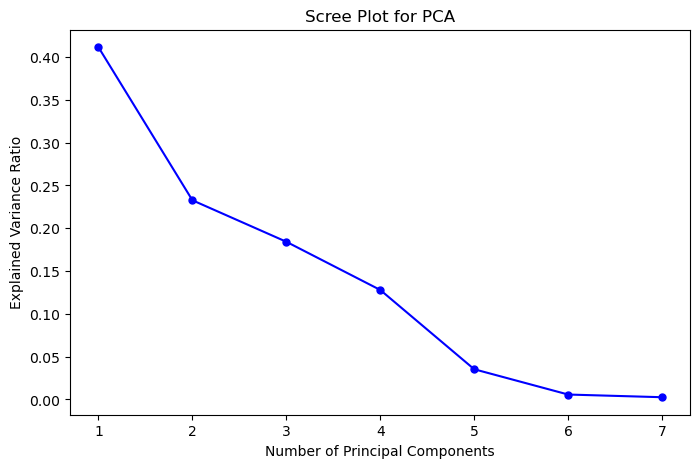

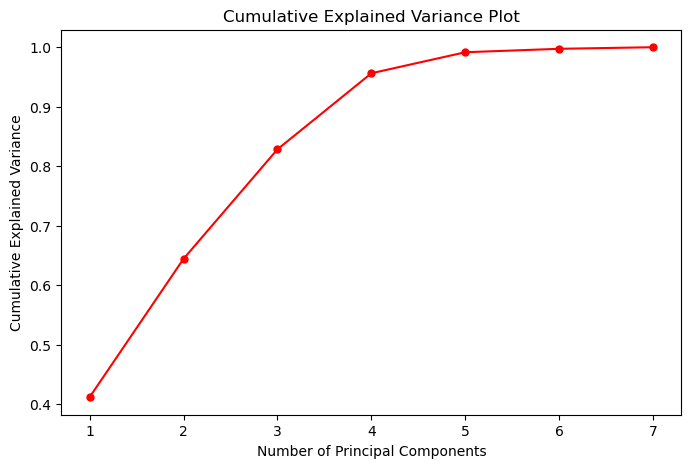

In [28]:
# PCA
pca = PCA()
pca.fit(df_features_normalized)


# explained variance ratio for principal components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-', markersize=5)
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.show()

# cumulative explained variance plot to find optimal number of components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 'ro-', markersize=5)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.show()


In [29]:
# number of principal components
n_components = 4 

pca = PCA(n_components=n_components)
df_features_pca = pca.fit_transform(df_features_normalized)

df_pca = pd.DataFrame(df_features_pca, columns=[f'PC{i+1}' for i in range(n_components)])
df_pca['tx_hash'] = tx_hashes


In [30]:
df_pca

PC1       PC2       PC3       PC4  \
0        11.788051  4.305396  6.205893 -4.053201   
1         5.424898  1.009296  7.774559 -2.342398   
2         5.394753  0.984641  7.742047 -2.361642   
3         4.939338  0.613046  7.107419 -2.167373   
4         7.778092  6.042585  6.548459  4.790874   
...            ...       ...       ...       ...   
4501286   9.929970  4.212509 -7.284168 -2.282744   
4501287   0.648596 -2.575969  1.758697  0.348395   
4501288  -0.085444 -2.577541  2.310925  0.181290   
4501289  -0.117520  0.429188  0.345616 -0.323704   
4501290  -0.124928  0.432624  0.359272 -0.324760   

                                                   tx_hash  
0        d8f5593d37433dcc02c88c28995a94cbf18a7325714e9a...  
1        695728f2b0676df9465e916f0fffed4ac9636f84f9512d...  
2        00cc6d2de92f52d9ec8607122d7db9e9732873bf1e0eb7...  
3        e8eb24dc001a3f42a9c5c0213aaedfec0dc8a882bf8aee...  
4        af01009a081b3b3d2920227b6696d5e5cc4e2b2acb5469...  
...                                                    ...  
4501286  bc8602f437fe94125df11992ba70010c1e79167c37ad75...  
4501287  d6e195d3fd008c358faaa336656065fb8524662fa4fd8d...  
4501288  3c5a7642c175c9d1c5f3998462ca36a925c802339cbf06...  
4501289  3d8a9f14c20bd2c9387095b25aba4725e60fd922f99c29...  
4501290  43bf052d6df274fd4d3f27e5bf8de57b55c7f87e4632cb...  

[4501291 rows x 5 columns]

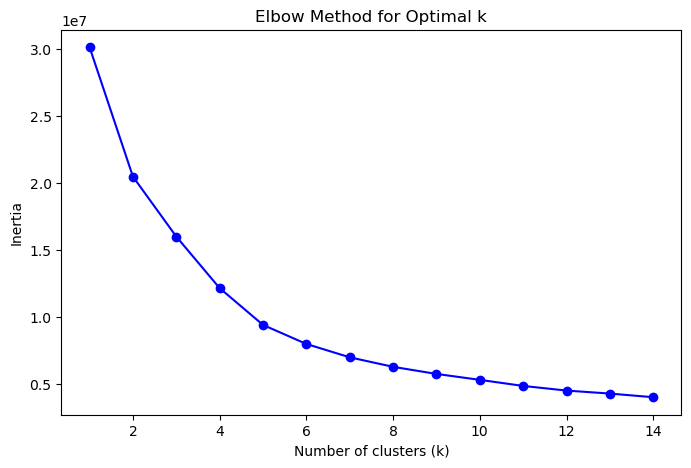

In [31]:
# defining number of clusters using the elbow method
inertia = []
K = range(1, 15)
for k in K:
    start_time = time.time()

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca.drop(columns=['tx_hash']))

    inertia.append(kmeans.inertia_)

    end_time = time.time()

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [32]:
# k-means with the chosen number of clusters
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(df_pca[['PC1', 'PC2', 'PC3', 'PC4']])

df_pca['cluster'] = clusters

cluster_means = df_pca.drop(columns=['tx_hash']).groupby('cluster').mean()
print("Mean values of each feature for each cluster:")
print(cluster_means)

Mean values of each feature for each cluster:
              PC1       PC2       PC3       PC4
cluster                                        
0       -0.601287  0.157622 -0.133568 -0.056366
1        5.335183 -1.005783 -2.055228 -0.215913
2        0.985786 -2.671261  1.393761  0.252365
3        2.899741  2.815568  2.460131  0.839718


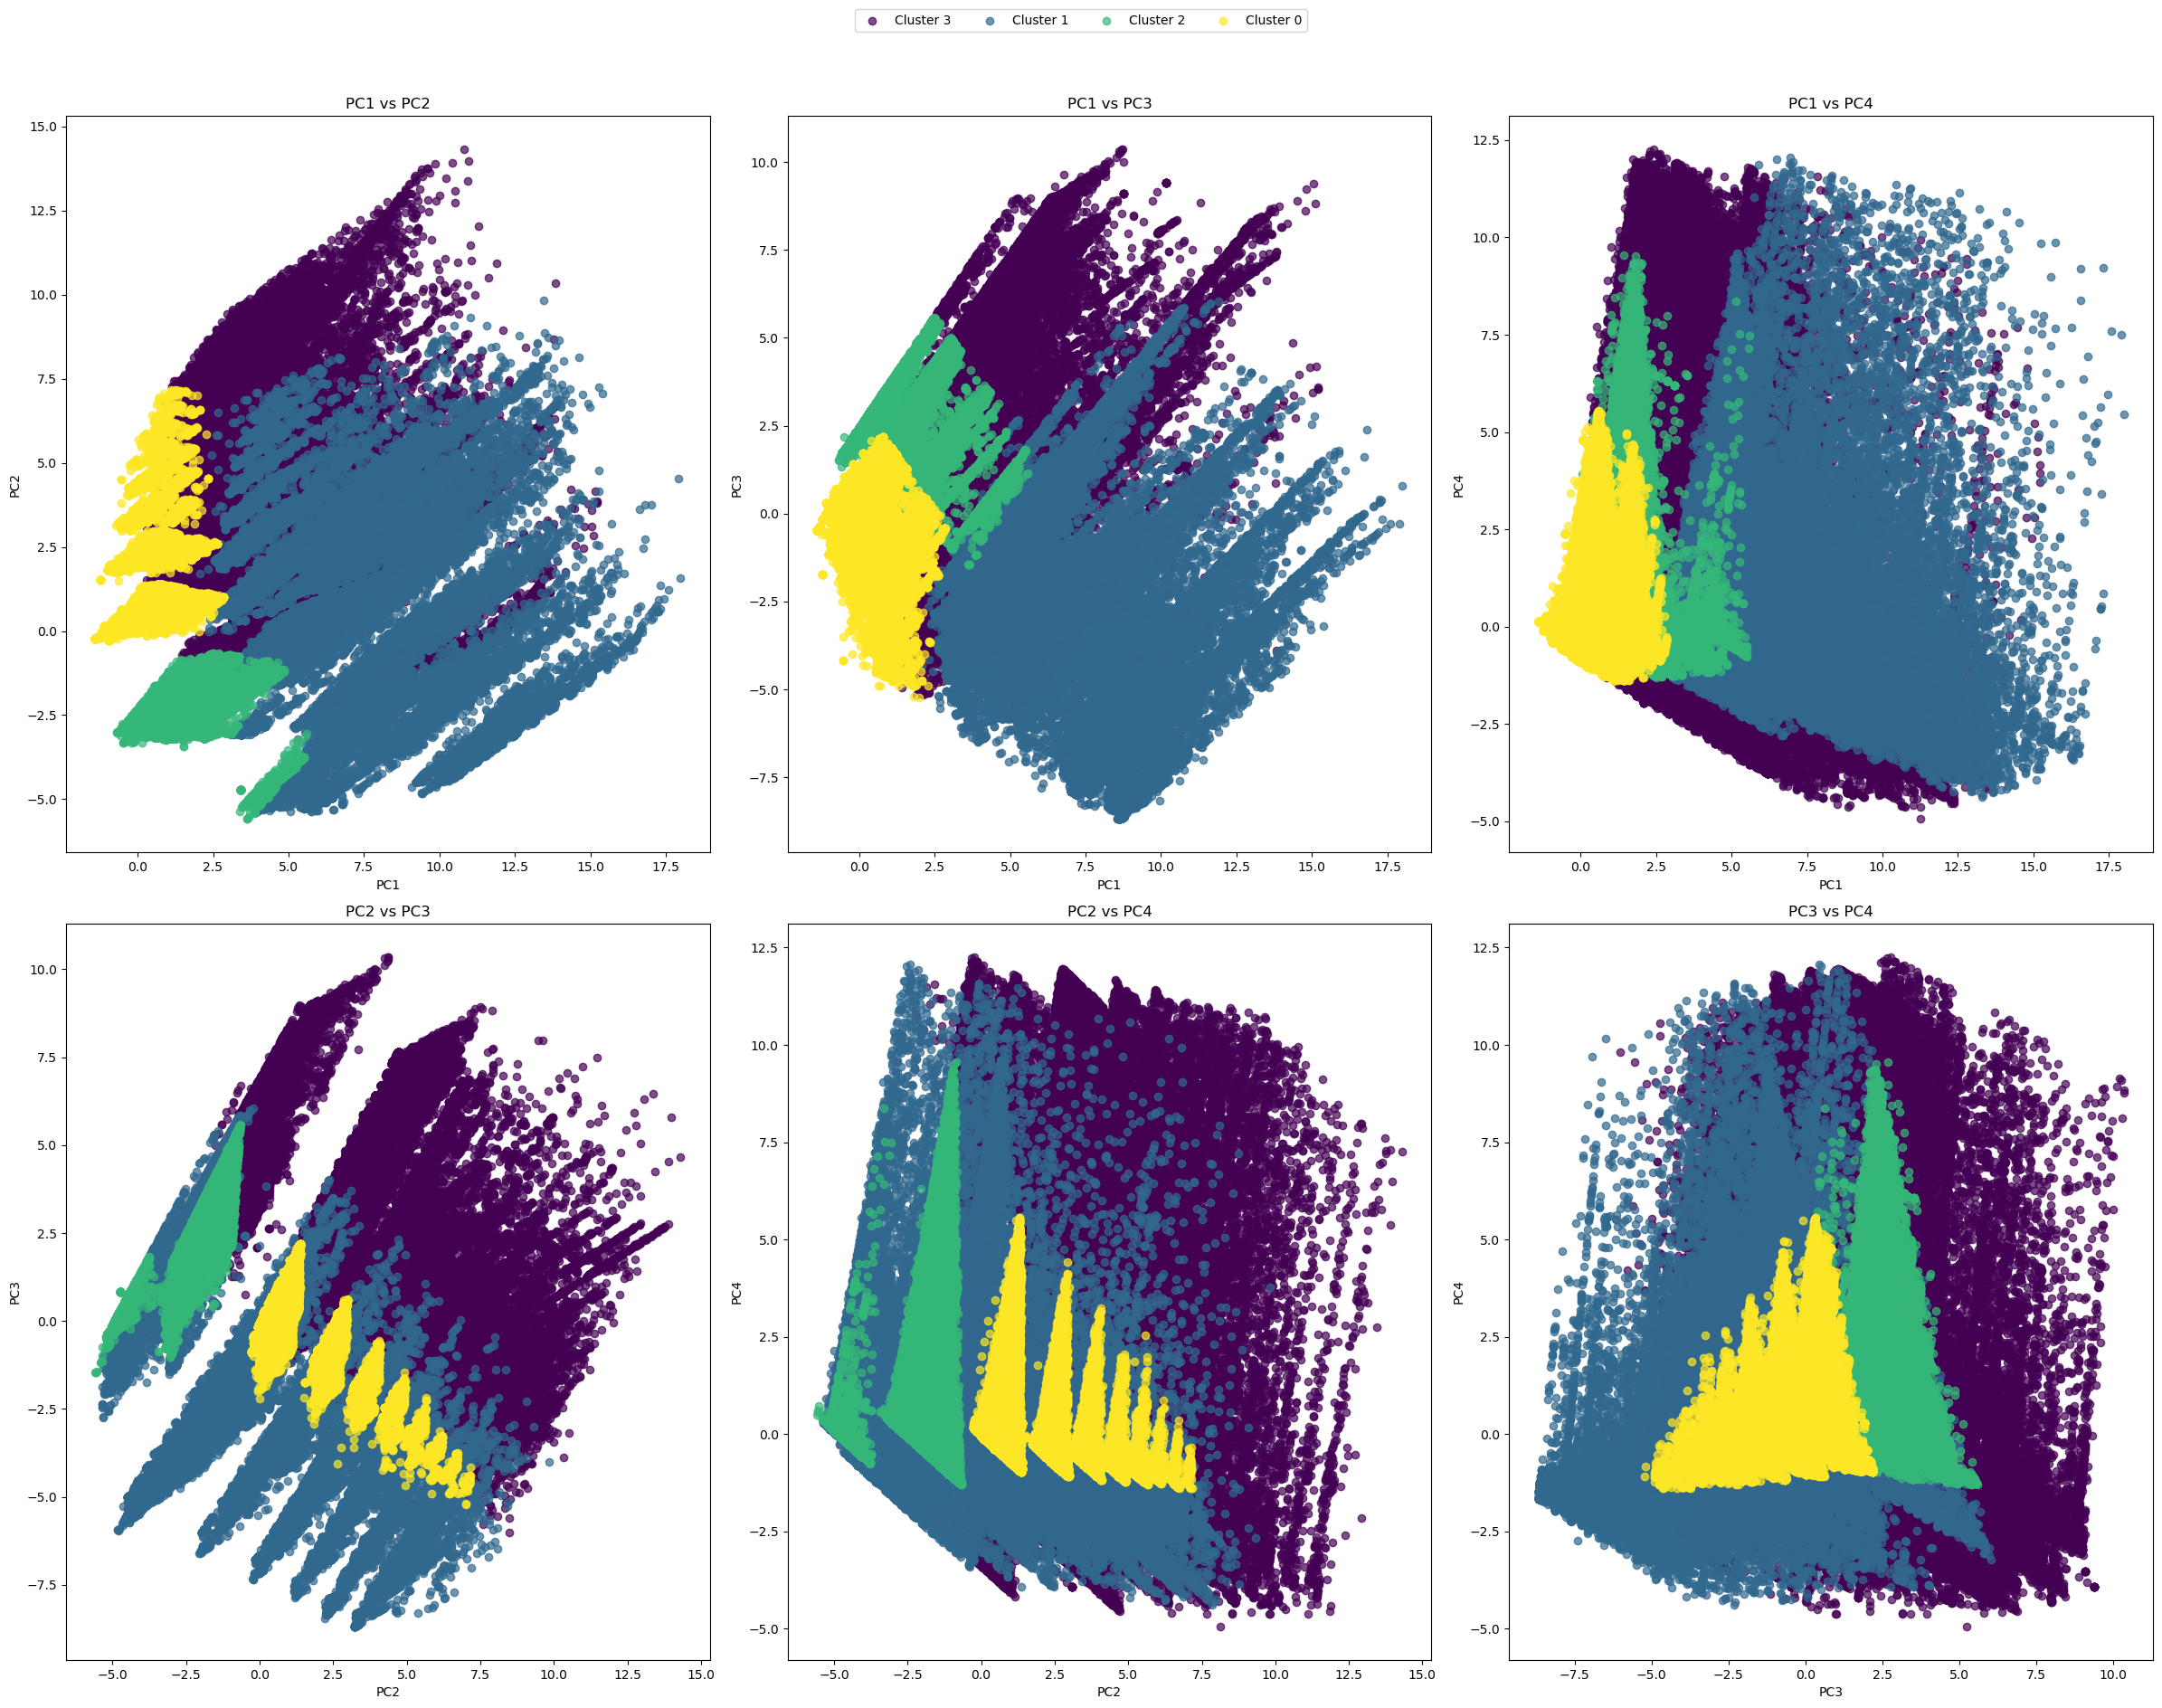

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(24, 18))

unique_clusters = df_pca['cluster'].unique()
color_palette = plt.cm.viridis(np.linspace(0, 1, 4))
colors = {
    0: color_palette[3],  
    1: color_palette[1],  
    2: color_palette[2],  
    3: color_palette[0]  
}

# all pairs of principal components to plot
pairs = [
    ('PC1', 'PC2'), ('PC1', 'PC3'), ('PC1', 'PC4'), ('PC2', 'PC3'), ('PC2', 'PC4'), ('PC3', 'PC4')
   ## , ('PC1', 'PC5'), ('PC2', 'PC5'), ('PC3', 'PC5'), ('PC4', 'PC5') ## for testing on 5 pca components
]

# loop through each subplot position and plot the corresponding pair
for i, (pc_x, pc_y) in enumerate(pairs):
    ax = axes[i // 3, i % 3]  # Determine subplot position

    for cluster in unique_clusters:
        subset = df_pca[df_pca['cluster'] == cluster]
        ax.scatter(subset[pc_x], subset[pc_y], color=colors[cluster], alpha=0.7, label=f'Cluster {cluster}')
    
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.set_title(f'{pc_x} vs {pc_y}')

# Add legend to the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(unique_clusters))

plt.tight_layout()
plt.show()


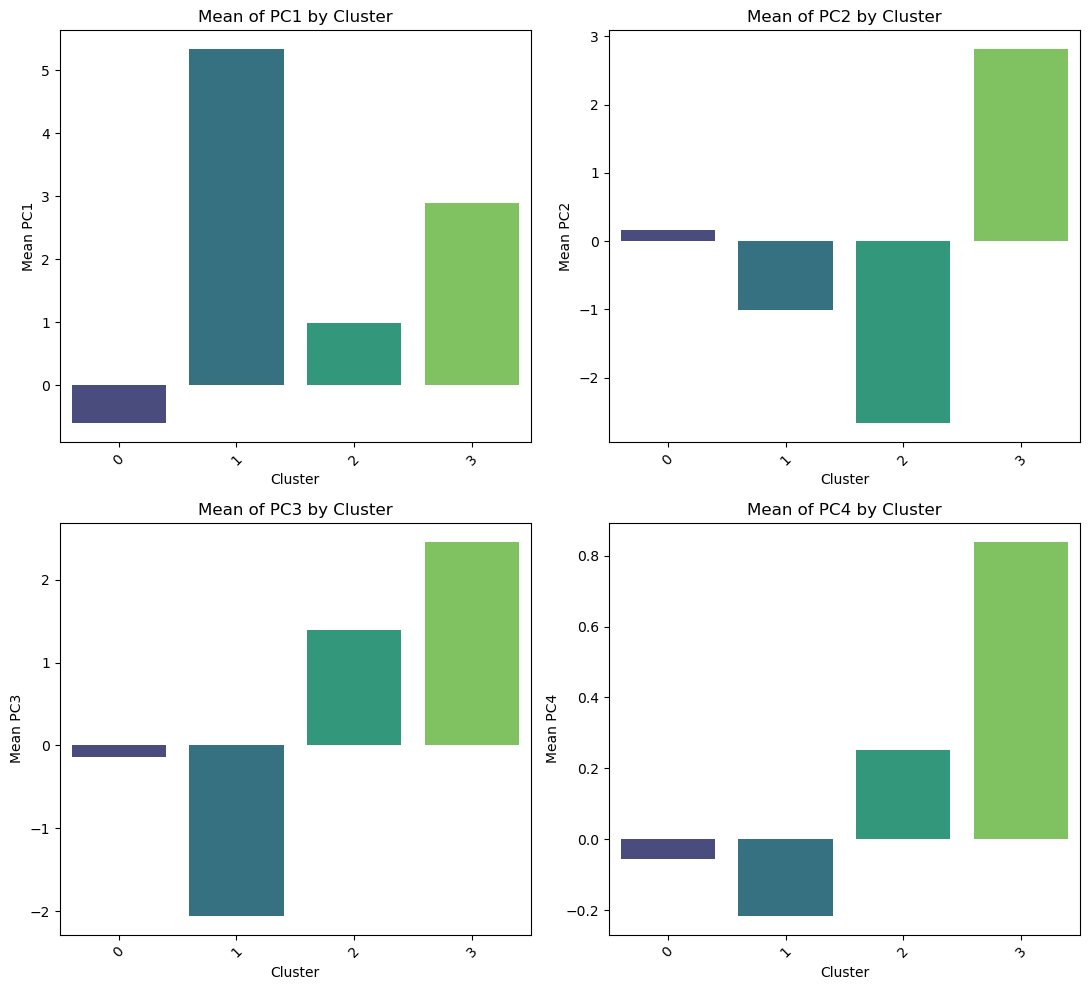

In [39]:
plt.figure(figsize=(11, 10))
for i, feature in enumerate(cluster_means.columns, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x=cluster_means.index, y=cluster_means[feature], hue=cluster_means.index, palette='viridis', dodge=False)
    plt.title(f'Mean of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature}')
    plt.xticks(rotation=45)
    plt.legend([],[], frameon=False)  # Hide the legend
plt.tight_layout()
plt.show()

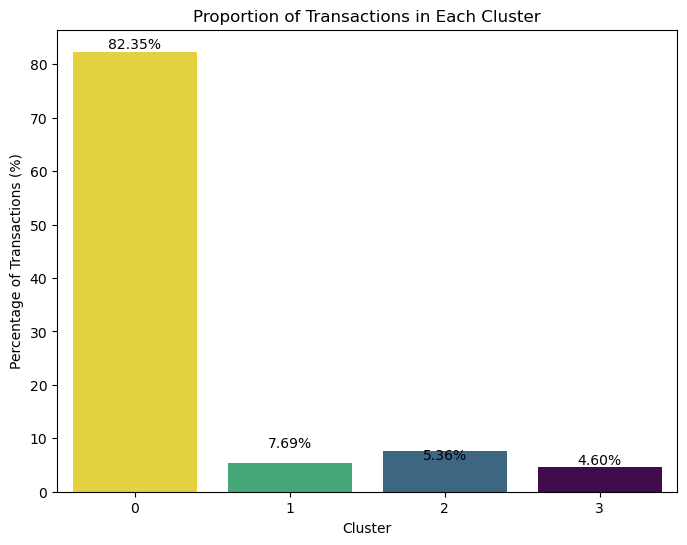

In [42]:
# number of transactions in each cluster
cluster_counts = df_pca['cluster'].value_counts()

# total number of transactions in the subset
total_transactions = len(df_pca)

# percentage of transactions in each cluster
cluster_percentages = (cluster_counts / total_transactions) * 100

# ensuring cluster order is maintained as in the PCA visualization
cluster_order = cluster_percentages.index


# clusters and their colors (colors should match the PCA plot)
unique_clusters = df_pca['cluster'].unique()
color_palette = plt.cm.viridis(np.linspace(0, 1, 4))

# color mapping for clusters
color_mapping = {
    0: color_palette[3],  
    1: color_palette[1],  
    2: color_palette[2],  
    3: color_palette[0]  
}

bar_colors = [color_mapping[cluster] for cluster in cluster_order]

plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette=bar_colors)  # Use percentages for y values
plt.title('Proportion of Transactions in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Transactions (%)')

# percentage values above each bar
for i, percentage in enumerate(cluster_percentages.values):
    plt.text(i, percentage + 0.05, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()


In [43]:
cluster_0 = df_pca[df_pca['cluster'] == 0]
print(f"\nCluster 0 Details:\nTotal transactions: {len(cluster_0)}")
print(cluster_0.describe())


Cluster 0 Details:
Total transactions: 3707007
                PC1           PC2           PC3           PC4    cluster
count  3.707007e+06  3.707007e+06  3.707007e+06  3.707007e+06  3707007.0
mean  -6.012865e-01  1.576222e-01 -1.335682e-01 -5.636649e-02        0.0
std    3.741291e-01  3.824710e-01  3.951447e-01  2.834721e-01        0.0
min   -1.402108e+00 -2.786328e-01 -5.227736e+00 -1.391656e+00        0.0
25%   -7.562597e-01  1.931596e-03 -3.183878e-01 -7.466211e-02        0.0
50%   -7.197882e-01  3.941666e-02 -2.692873e-01 -4.021423e-02        0.0
75%   -6.513898e-01  1.148686e-01 -7.913262e-03 -2.228148e-02        0.0
max    2.850229e+00  7.169980e+00  2.181999e+00  5.559200e+00        0.0


## Scraped data extention

In [45]:
sample_file_path = 'labelled_addresses_scraper/scraper/Services_others/walletexplorer-GreenRoadMarket-00adc4a2b0fbd07c-addresses-1.csv'
df = pd.read_csv(sample_file_path)
print(df.columns)

Index(['#Wallet GreenRoadMarket (00adc4a2b0fbd07c), page 1 from 10, addresses 1-100. Updated to block 858677 (2024-08-27 17:49:35 UTC). Source: WalletExplorer.com'], dtype='object')


In [46]:
input_file = "labelled_addresses_scraper/Exchanges_addresses.csv"
data_preview = pd.read_csv(input_file)
print(data_preview.head())  
print(data_preview.columns) 

                              address
0  1EhWAtxucFKSeCsZT3Q9fcPntaELfhacnA
1  39P56ExsBygR5wWNKMTmQNxqKPWcExEP6a
2  3NLfvRZt8WgjirZSKYf43Eo34sTb9GGxrs
3  39cgwnL62xLtuCV11S542XeoSBiTZyTsdL
4  3QdQ4yLpcSiSbSYtfv9vcziMuPtu1AynPb
Index(['address'], dtype='object')


In [47]:
##labeled_transactions = pd.read_csv('/content/drive/MyDrive/data_bit/labeled_transactions.csv')

labeled_transactions = pd.read_csv('labeled_transactions.csv')
print(labeled_transactions.head())


                                             tx_hash            Label
0  5cd24723255f68f8536ca6fe1df35df80070e311545188...        Exchanges
1  8dd632ced6e47bbe15c0ed2c41a0378f4024e171ce567c...        Exchanges
2  f4daccc4614e3ea4ee67def4800f98ef052c0a5092b6fd...  Services_others
3  9481633e2177c8d37e244fcf763f95f05d29bfeae4a03f...        Exchanges
4  c662ebee3f351f658086306e5d6eecd634c6d15f3ecad1...        Exchanges


In [48]:
# merging with transaction labels to analyze the distribution across clusters
merged_data = pd.merge(df_pca, labeled_transactions, on='tx_hash', how='left')

merged_data


PC1       PC2       PC3       PC4  \
0        11.788051  4.305396  6.205893 -4.053201   
1         5.424898  1.009296  7.774559 -2.342398   
2         5.394753  0.984641  7.742047 -2.361642   
3         4.939338  0.613046  7.107419 -2.167373   
4         7.778092  6.042585  6.548459  4.790874   
...            ...       ...       ...       ...   
4501286   9.929970  4.212509 -7.284168 -2.282744   
4501287   0.648596 -2.575969  1.758697  0.348395   
4501288  -0.085444 -2.577541  2.310925  0.181290   
4501289  -0.117520  0.429188  0.345616 -0.323704   
4501290  -0.124928  0.432624  0.359272 -0.324760   

                                                   tx_hash  cluster Label  
0        d8f5593d37433dcc02c88c28995a94cbf18a7325714e9a...        3   NaN  
1        695728f2b0676df9465e916f0fffed4ac9636f84f9512d...        3   NaN  
2        00cc6d2de92f52d9ec8607122d7db9e9732873bf1e0eb7...        3   NaN  
3        e8eb24dc001a3f42a9c5c0213aaedfec0dc8a882bf8aee...        3   NaN  
4        af01009a081b3b3d2920227b6696d5e5cc4e2b2acb5469...        3   NaN  
...                                                    ...      ...   ...  
4501286  bc8602f437fe94125df11992ba70010c1e79167c37ad75...        1   NaN  
4501287  d6e195d3fd008c358faaa336656065fb8524662fa4fd8d...        2   NaN  
4501288  3c5a7642c175c9d1c5f3998462ca36a925c802339cbf06...        2   NaN  
4501289  3d8a9f14c20bd2c9387095b25aba4725e60fd922f99c29...        0   NaN  
4501290  43bf052d6df274fd4d3f27e5bf8de57b55c7f87e4632cb...        0   NaN  

[4501291 rows x 7 columns]

In [49]:
merged_data['Label'] = merged_data['Label'].fillna('unknown')
merged_data

PC1       PC2       PC3       PC4  \
0        11.788051  4.305396  6.205893 -4.053201   
1         5.424898  1.009296  7.774559 -2.342398   
2         5.394753  0.984641  7.742047 -2.361642   
3         4.939338  0.613046  7.107419 -2.167373   
4         7.778092  6.042585  6.548459  4.790874   
...            ...       ...       ...       ...   
4501286   9.929970  4.212509 -7.284168 -2.282744   
4501287   0.648596 -2.575969  1.758697  0.348395   
4501288  -0.085444 -2.577541  2.310925  0.181290   
4501289  -0.117520  0.429188  0.345616 -0.323704   
4501290  -0.124928  0.432624  0.359272 -0.324760   

                                                   tx_hash  cluster    Label  
0        d8f5593d37433dcc02c88c28995a94cbf18a7325714e9a...        3  unknown  
1        695728f2b0676df9465e916f0fffed4ac9636f84f9512d...        3  unknown  
2        00cc6d2de92f52d9ec8607122d7db9e9732873bf1e0eb7...        3  unknown  
3        e8eb24dc001a3f42a9c5c0213aaedfec0dc8a882bf8aee...        3  unknown  
4        af01009a081b3b3d2920227b6696d5e5cc4e2b2acb5469...        3  unknown  
...                                                    ...      ...      ...  
4501286  bc8602f437fe94125df11992ba70010c1e79167c37ad75...        1  unknown  
4501287  d6e195d3fd008c358faaa336656065fb8524662fa4fd8d...        2  unknown  
4501288  3c5a7642c175c9d1c5f3998462ca36a925c802339cbf06...        2  unknown  
4501289  3d8a9f14c20bd2c9387095b25aba4725e60fd922f99c29...        0  unknown  
4501290  43bf052d6df274fd4d3f27e5bf8de57b55c7f87e4632cb...        0  unknown  

[4501291 rows x 7 columns]

In [50]:
# grouping by label and cluster to see the distribution
cluster_distribution = merged_data.groupby(['Label', 'cluster']).size().reset_index(name='counts')
print(cluster_distribution)

              Label  cluster   counts
0         Exchanges        0       43
1         Exchanges        1       28
2         Exchanges        2       32
3         Exchanges        3       32
4          Gambling        1        1
5   Services_others        0        4
6   Services_others        1       14
7   Services_others        3        6
8           unknown        0  3706960
9           unknown        1   241352
10          unknown        2   345926
11          unknown        3   206893



Category: Exchanges
       Label  cluster  counts
0  Exchanges        0      43
1  Exchanges        1      28
2  Exchanges        2      32
3  Exchanges        3      32

Category: Services_others
             Label  cluster  counts
5  Services_others        0       4
6  Services_others        1      14
7  Services_others        3       6

Category: Gambling
      Label  cluster  counts
4  Gambling        1       1


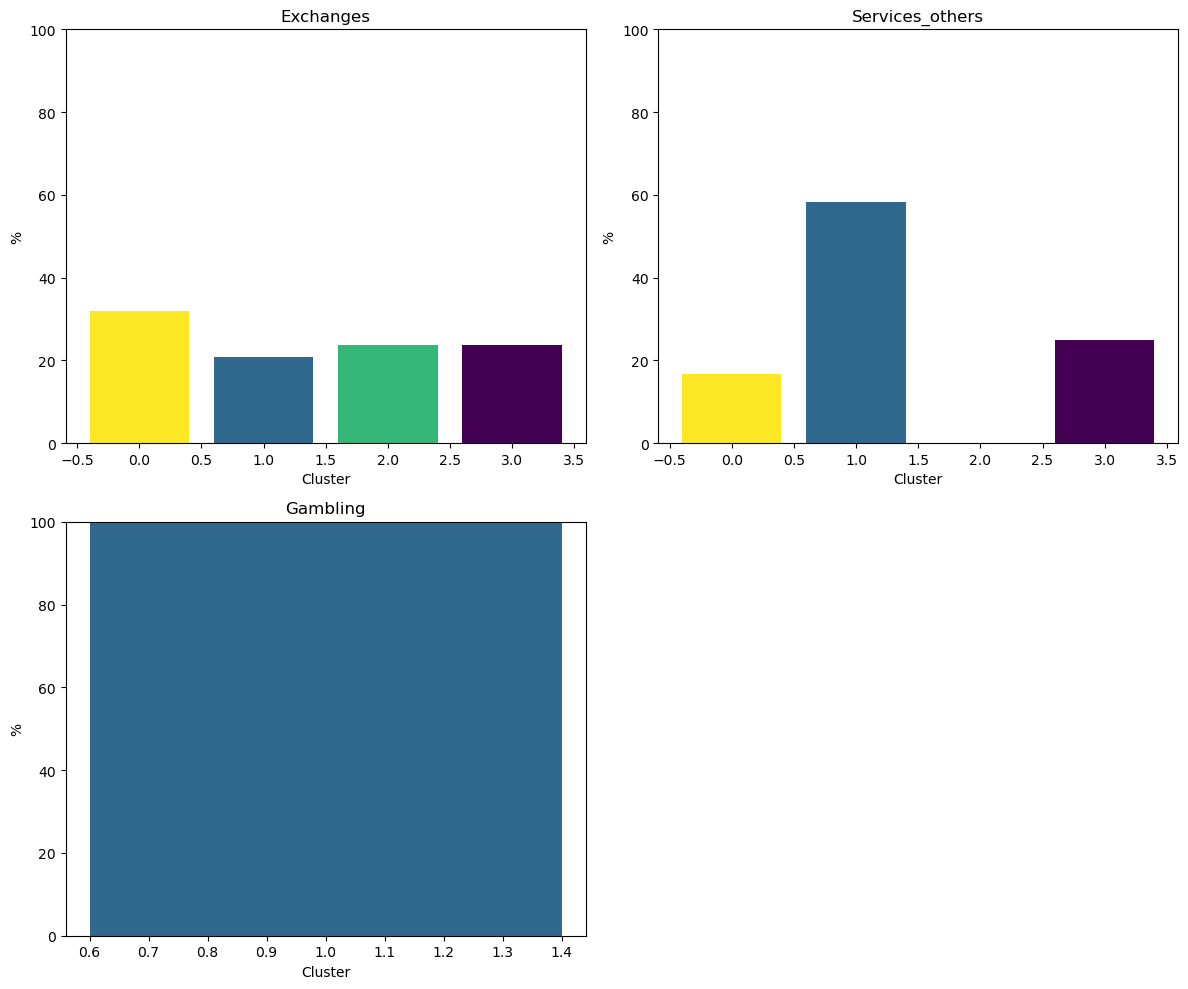

In [51]:
# color palette matching the order
color_palette = plt.cm.viridis(np.linspace(0, 1, 4))

color_dict = {
    0: color_palette[3],  
    1: color_palette[1],  
    2: color_palette[2],  
    3: color_palette[0]  }


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

categories = ['Exchanges', 'Services_others', 'Gambling', 'Pools']

for idx, category in enumerate(categories):
    ax = axs[idx // 2, idx % 2]  # Determine subplot position
    category_data = cluster_distribution[cluster_distribution['Label'] == category]
    
    if not category_data.empty:
        print(f"\nCategory: {category}")
        print(category_data)

        cluster_counts = category_data['counts'].values
        clusters = category_data['cluster'].values
        
        clusters = np.round(clusters).astype(int)
        
        cluster_percentages = (cluster_counts / cluster_counts.sum()) * 100

        ax.bar(clusters, cluster_percentages, color=[color_dict.get(cluster, 'gray') for cluster in clusters])
        ax.set_title(category)
        ax.set_xlabel('Cluster')
        ax.set_ylabel('%')
        ax.set_ylim(0, 100)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


# Outlook

## Graph based Feature Extraction

In [ ]:
def create_feature_vector(graph, address, address_index):
    address_vertex = graph.vertex(address_index)

    in_edges = list(address_vertex.in_edges())
    out_edges = list(address_vertex.out_edges())
    in_degree = len(in_edges)
    out_degree = len(out_edges)
    total_degree = in_degree + out_degree

    tx_type_counts = defaultdict(int)
    in_amounts = defaultdict(list)
    out_amounts = defaultdict(list)
    times = []

    for e in in_edges:
        tx_type = graph.ep["tx_type"][e]
        tx_type_counts[f"in_{tx_type}"] += 1
        in_amounts[tx_type].append(graph.ep["value"][e])
        times.append(graph.ep["time"][e])

    for e in out_edges:
        tx_type = graph.ep["tx_type"][e]
        tx_type_counts[f"out_{tx_type}"] += 1
        out_amounts[tx_type].append(graph.ep["value"][e])
        times.append(graph.ep["time"][e])

    total_in_amount = sum(sum(amounts) for amounts in in_amounts.values())
    total_out_amount = sum(sum(amounts) for amounts in out_amounts.values())
    net_value = total_in_amount - total_out_amount

    avg_in_amount = total_in_amount / in_degree if in_degree > 0 else 0
    avg_out_amount = total_out_amount / out_degree if out_degree > 0 else 0

    in_out_amount_ratio = total_in_amount / total_out_amount if total_out_amount > 0 else (np.inf if total_in_amount > 0 else 0)
    in_out_degree_ratio = in_degree / out_degree if out_degree > 0 else (np.inf if in_degree > 0 else 0)

    if times:
        life_cycle = max(times) - min(times)
        avg_time_between = life_cycle / (len(times) - 1) if len(times) > 1 else 0
        first_activity = min(times)
        last_activity = max(times)
    else:
        life_cycle = avg_time_between = first_activity = last_activity = 0

    all_in_amounts = [amount for amounts in in_amounts.values() for amount in amounts]
    if all_in_amounts:
        sorted_amounts = np.sort(all_in_amounts)
        index = np.arange(1, len(sorted_amounts) + 1)
        n = len(sorted_amounts)
        amounts_sum = sorted_amounts.sum()
        if amounts_sum > 0:
            gini = ((2 * index - n - 1) * sorted_amounts).sum() / (n * amounts_sum)
        else:
            gini = 0
    else:
        gini = 0

    return {
        'address': address,
        'in_degree': in_degree,
        'out_degree': out_degree,
        'total_degree': total_degree,
        'total_in_amount': total_in_amount,
        'total_out_amount': total_out_amount,
        'net_value': net_value,
        'avg_in_amount': avg_in_amount,
        'avg_out_amount': avg_out_amount,
        'in_out_amount_ratio': in_out_amount_ratio,
        'in_out_degree_ratio': in_out_degree_ratio,
        'life_cycle': life_cycle,
        'avg_time_between': avg_time_between,
        'first_activity': first_activity,
        'last_activity': last_activity,
        'gini_coefficient': gini,
        **tx_type_counts,
    }

def extract_features(graph, reverse_map):
    feature_vectors = {}
    for addr, index in tqdm(reverse_map['account_dict'].items(), total=len(reverse_map['account_dict'])):
        features = create_feature_vector(graph, addr, index)
        feature_vectors[addr] = features
    return feature_vectors


feature_vectors = extract_features(graph, reverse_map)

import pandas as pd
df_features = pd.DataFrame.from_dict(feature_vectors, orient='index')
df_features.to_csv("bitcoin_address_features.csv")

print("Feature extraction complete. Results saved to 'bitcoin_address_features.csv'")

print("\nFeature Statistics:")
print(df_features.describe())

print("\nMissing Values:")
print(df_features.isnull().sum())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1472066/1472066 [1:08:41<00:00, 357.17it/s]


Feature extraction complete. Results saved to 'bitcoin_address_features.csv'

Feature Statistics:


/Users/ekaterinabasova/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ekaterinabasova/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


          in_degree    out_degree  total_degree  total_in_amount  \
count  1.472066e+06  1.472066e+06  1.472066e+06     1.472066e+06   
mean   3.937224e+00  2.637420e+00  6.574645e+00     1.661990e-08   
std    1.331384e+03  3.199949e+03  3.478867e+03     4.984633e-06   
min    1.000000e+00  0.000000e+00  1.000000e+00     0.000000e+00   
25%    1.000000e+00  0.000000e+00  1.000000e+00     4.060600e-12   
50%    1.000000e+00  0.000000e+00  1.000000e+00     1.604280e-11   
75%    1.000000e+00  0.000000e+00  1.000000e+00     9.218890e-11   
max    1.606568e+06  3.882457e+06  3.899573e+06     5.460492e-03   

       total_out_amount     net_value  avg_in_amount  avg_out_amount  \
count         1472066.0  1.472066e+06   1.472066e+06       1472066.0   
mean                0.0  1.661990e-08   3.650457e-09             0.0   
std                 0.0  4.984633e-06   5.096965e-07             0.0   
min                 0.0  0.000000e+00   0.000000e+00             0.0   
25%                 0.0  4.

## Clustering based on manually retrieved data

In [ ]:
df_features = pd.read_csv("bitcoin_address_features.csv")
if df_features.empty:
    print("No features were extracted. DataFrame is empty. Please check the input data and try again.")
else:
    print("\nFeature Statistics:")
    print(df_features.describe())

    print("\nMissing Values:")
    print(df_features.isnull().sum())


Feature Statistics:


/Users/ekaterinabasova/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ekaterinabasova/miniconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


          in_degree    out_degree  total_degree  total_in_amount  \
count  1.472066e+06  1.472066e+06  1.472066e+06     1.472066e+06   
mean   3.937224e+00  2.637420e+00  6.574645e+00     1.661990e-08   
std    1.331384e+03  3.199949e+03  3.478867e+03     4.984633e-06   
min    1.000000e+00  0.000000e+00  1.000000e+00     0.000000e+00   
25%    1.000000e+00  0.000000e+00  1.000000e+00     4.060600e-12   
50%    1.000000e+00  0.000000e+00  1.000000e+00     1.604280e-11   
75%    1.000000e+00  0.000000e+00  1.000000e+00     9.218890e-11   
max    1.606568e+06  3.882457e+06  3.899573e+06     5.460492e-03   

       total_out_amount     net_value  avg_in_amount  avg_out_amount  \
count         1472066.0  1.472066e+06   1.472066e+06       1472066.0   
mean                0.0  1.661990e-08   3.650457e-09             0.0   
std                 0.0  4.984633e-06   5.096965e-07             0.0   
min                 0.0  0.000000e+00   0.000000e+00             0.0   
25%                 0.0  4.

          in_degree  out_degree  total_degree  total_in_amount  \
count  1.472064e+06   1472064.0  1.472064e+06     1.472064e+06   
mean   2.834231e+00         0.0  2.834231e+00     1.661992e-08   
std    1.379506e+02         0.0  1.379506e+02     4.984636e-06   
min    1.000000e+00         0.0  1.000000e+00     2.940000e-14   
25%    1.000000e+00         0.0  1.000000e+00     4.060600e-12   
50%    1.000000e+00         0.0  1.000000e+00     1.604280e-11   
75%    1.000000e+00         0.0  1.000000e+00     9.218850e-11   
max    1.228840e+05         0.0  1.228840e+05     5.460492e-03   

       total_out_amount     net_value  avg_in_amount    life_cycle  \
count         1472064.0  1.472064e+06   1.472064e+06  1.472064e+06   
mean                0.0  1.661992e-08   3.650462e-09  1.697585e+04   
std                 0.0  4.984636e-06   5.096968e-07  5.509511e+04   
min                 0.0  2.940000e-14   2.940000e-14  0.000000e+00   
25%                 0.0  4.060600e-12   3.571000e-12  0

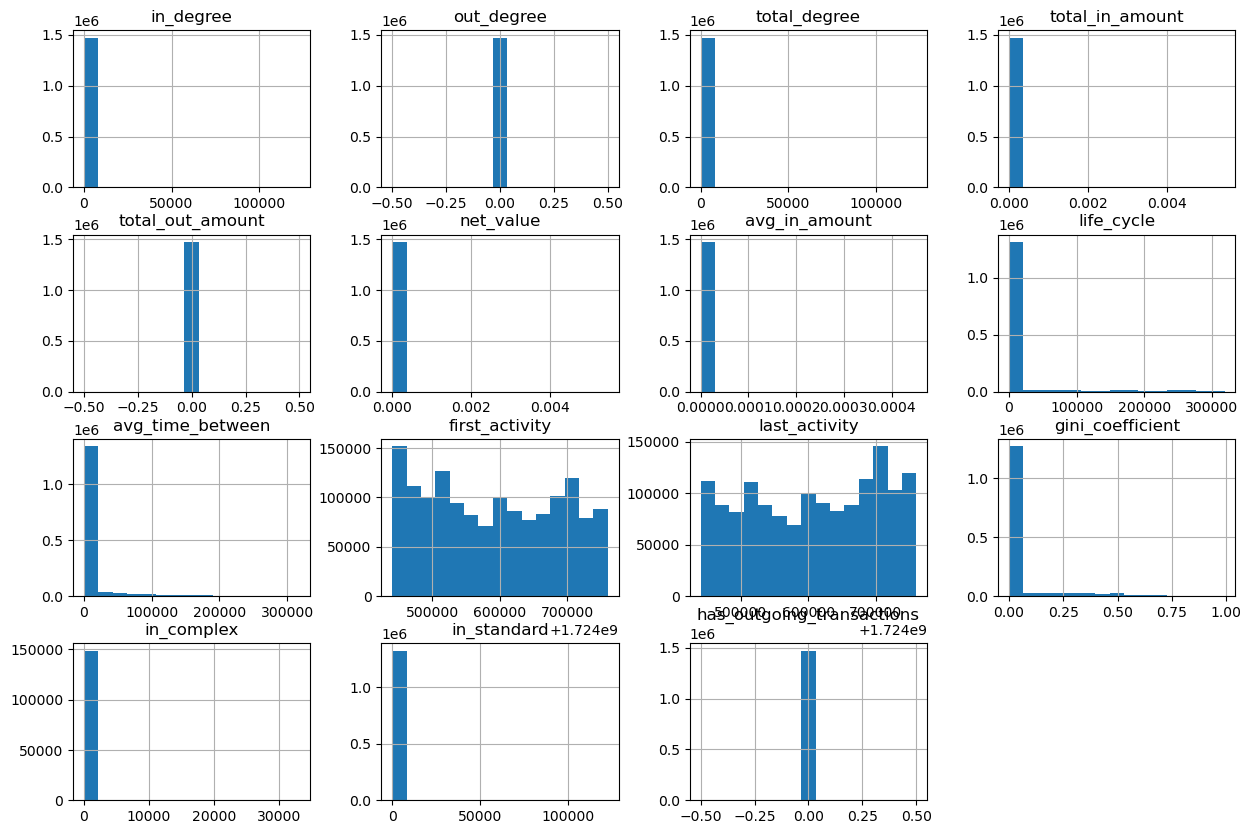

In [ ]:
df_features = df_features[~df_features['address'].isin(['unknown', 'OP_RETURN'])]

metrics_to_drop = ['in_op_return', 'out_standard', 'avg_out_amount', 'in_out_amount_ratio', 'in_out_degree_ratio']

df_features.drop(columns=metrics_to_drop, inplace=True)

df_features['has_outgoing_transactions'] = (df_features['out_degree'] > 0).astype(int)


print(df_features.describe())

df_features.hist(bins=15, figsize=(15, 10))
plt.show()



In [ ]:
df_features['log_in_degree'] = np.log1p(df_features['in_degree'])

df_features['activity_level'] = pd.cut(df_features['in_degree'], bins=[0, 1, 10, 100, 1000, np.inf], labels=['None', 'Low', 'Medium', 'High', 'Very High'])


          in_degree  out_degree  total_degree  total_in_amount  \
count  1.472064e+06   1472064.0  1.472064e+06     1.472064e+06   
mean   2.834231e+00         0.0  2.834231e+00     1.661992e-08   
std    1.379506e+02         0.0  1.379506e+02     4.984636e-06   
min    1.000000e+00         0.0  1.000000e+00     2.940000e-14   
25%    1.000000e+00         0.0  1.000000e+00     4.060600e-12   
50%    1.000000e+00         0.0  1.000000e+00     1.604280e-11   
75%    1.000000e+00         0.0  1.000000e+00     9.218850e-11   
max    1.228840e+05         0.0  1.228840e+05     5.460492e-03   

       total_out_amount     net_value  avg_in_amount    life_cycle  \
count         1472064.0  1.472064e+06   1.472064e+06  1.472064e+06   
mean                0.0  1.661992e-08   3.650462e-09  1.697585e+04   
std                 0.0  4.984636e-06   5.096968e-07  5.509511e+04   
min                 0.0  2.940000e-14   2.940000e-14  0.000000e+00   
25%                 0.0  4.060600e-12   3.571000e-12  0

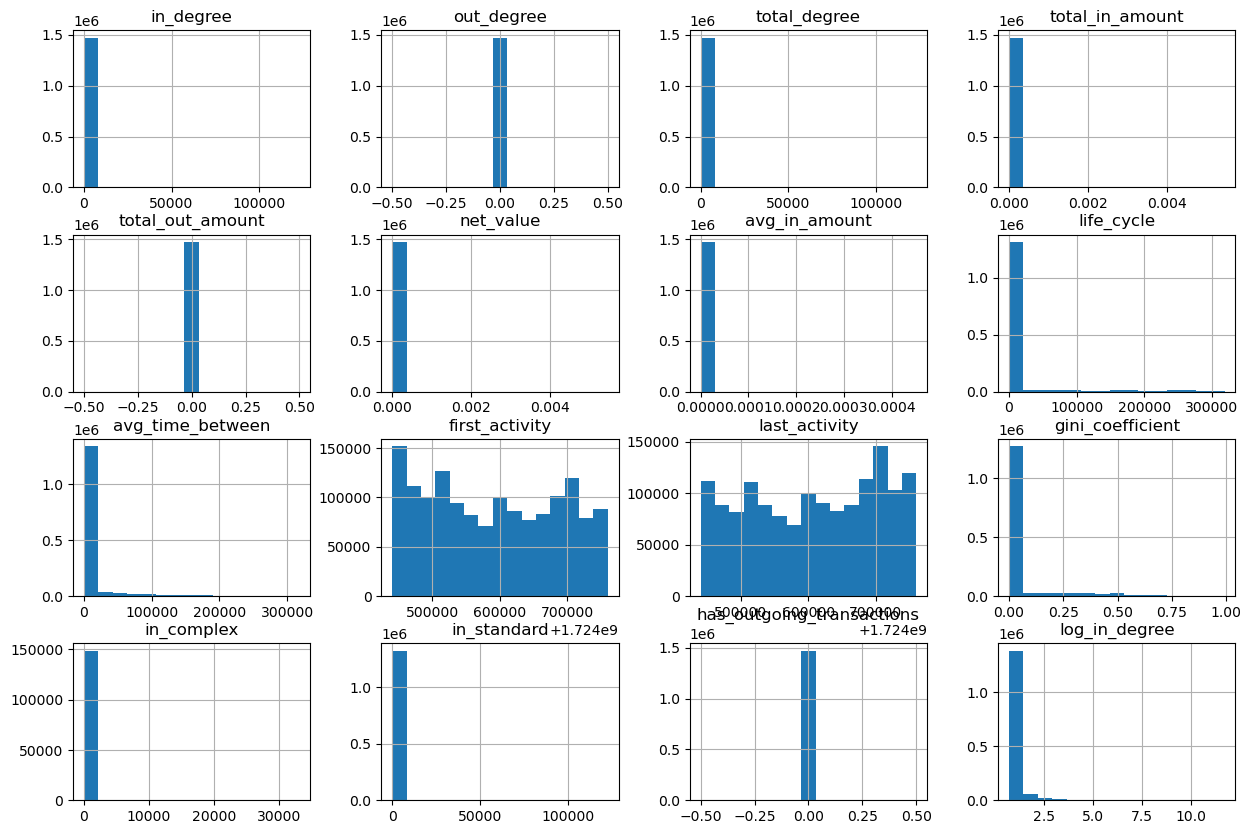

In [ ]:
print(df_features.describe())

# Plot histograms for all features
df_features.hist(bins=15, figsize=(15, 10))
plt.show()

relevant features could be:

- in_degree, out_degree, total_degree: Reflect transaction activity levels.
- total_in_amount, net_value, avg_in_amount: Reflect financial activity.
- life_cycle, avg_time_between: Reflect the temporal aspect of transactions.
- gini_coefficient: Reflect the distribution of transaction values.

In [ ]:

numeric_features = [
    'in_degree', 'out_degree', 'total_degree', 'total_in_amount',
    'net_value', 'avg_in_amount', 'life_cycle', 'avg_time_between',
    'gini_coefficient', 'log_in_degree'
]


df_features[numeric_features] = df_features[numeric_features].fillna(0)


scaler = StandardScaler()
df_features_normalized = scaler.fit_transform(df_features[numeric_features])


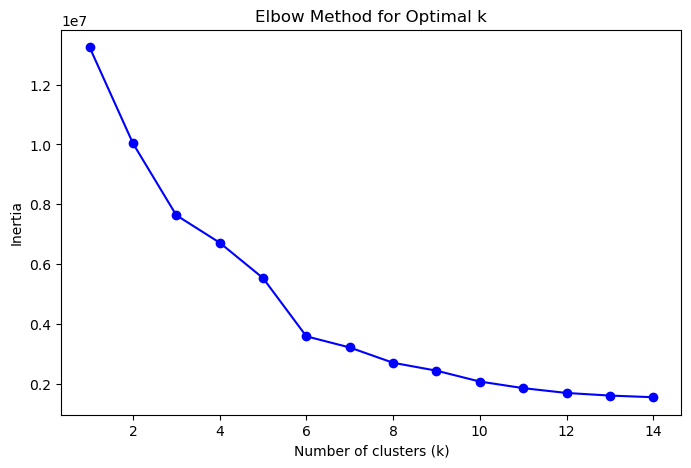

In [ ]:

inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_features_normalized)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(df_features_normalized)

df_features['cluster'] = clusters


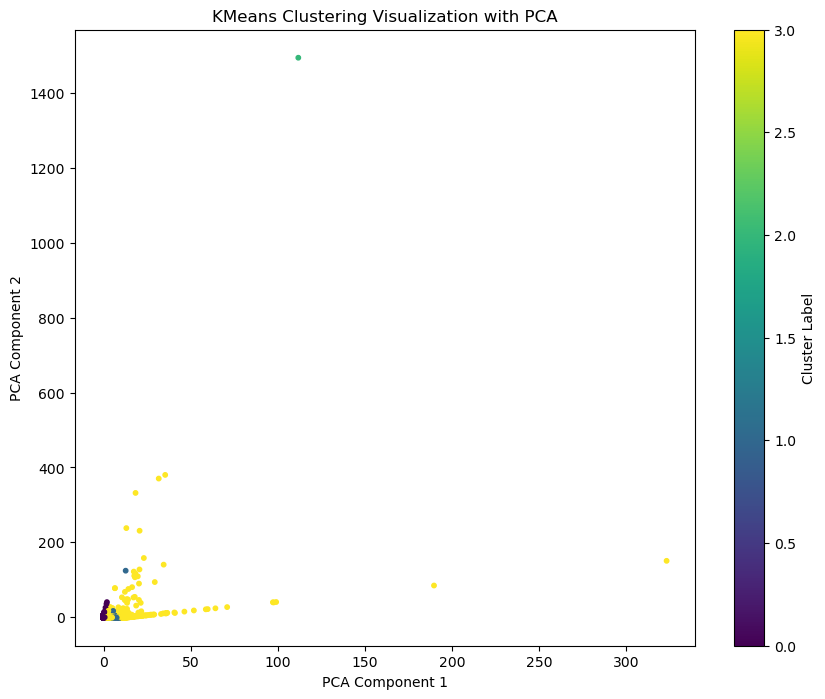

In [ ]:
pca = PCA(n_components=2)
df_features_pca = pca.fit_transform(df_features_normalized)

plt.figure(figsize=(10, 8))
plt.scatter(df_features_pca[:, 0], df_features_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering Visualization with PCA')
plt.colorbar(label='Cluster Label')
plt.show()


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
df_features_tsne = tsne.fit_transform(df_features_normalized)

plt.figure(figsize=(10, 8))
plt.scatter(df_features_tsne[:, 0], df_features_tsne[:, 1], c=clusters, cmap='viridis', s=10)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('KMeans Clustering Visualization with t-SNE')
plt.colorbar(label='Cluster Label')
plt.show()
